In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static
from tensorflow_probability.python.mcmc.transformed_kernel import make_transformed_log_prob

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
plt.style.use('arviz-darkgrid')

dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

In [3]:
# Generating data
mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, size=200)

In [4]:
# Defining the model
model = tfd.JointDistributionSequential([
    # sigma_prior
    tfd.Exponential(1),

    # mu_prior
    tfd.Normal(loc=0, scale=10),

    # likelihood
    lambda mu, sigma: tfd.Normal(loc=mu, scale=sigma, name="ll")
])

In [5]:
print(model.resolve_graph())

(('sigma', ()), ('mu', ()), ('ll', ('mu', 'sigma')))


In [6]:
# Let's generate joint log probability
joint_log_prob = lambda *samples: model.log_prob(samples + (data,))

In [7]:
contraining_bijectors = [
  tfb.Exp(),
  tfb.Identity()
]

def make_transformed_log_prob(joint_log_prob, contraining_bijectors):
    
    def transformed_log_prob(samples):
        constrained_samples = list()
        for bij, sample in zip(contraining_bijectors, samples):
            constrained_samples.append(bij.forward(sample))

        tlp = joint_log_prob(*constrained_samples)
        tlp_rank = prefer_static.rank(tlp) 
        event_ndims = [(prefer_static.rank(sp) - tlp_rank) for sp in samples]
        ldj = sum([
            bij.forward_log_det_jacobian(s, event_ndims=e)
            for bij, s, e in zip(contraining_bijectors, samples, event_ndims)
        ])
        return tlp + ldj
    return transformed_log_prob


transformed_log_prob = make_transformed_log_prob(joint_log_prob, contraining_bijectors)

In [8]:
# Build Mean Field ADVI
def build_mf_advi():
    parameters = model.sample(1)
    parameters.pop()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter[0].shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f'meanfield_{i}_loc',
            dtype=dtype
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(0.02, dtype=dtype)),
            tfb.Softplus(), # For positive values of scale
            name=f'meanfield_{i}_scale'
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)

meanfield_advi = build_mf_advi()

In [9]:
def loss_fn(posterior, target_log_prob):
    samples = posterior.sample(1)
    samples = posterior.log_prob(samples) - target_log_prob(samples)
    return tf.reduce_mean(samples, axis=0)  # Monte carlo expectation

In [10]:
opt = tf.optimizers.Adam(learning_rate=.1)

@tf.function(autograph=False)
def optimizer_fn():
    with tf.GradientTape() as tape:
        loss = loss_fn(meanfield_advi, transformed_log_prob)

    watched_variables = tape.watched_variables()
    grads = tape.gradient(loss, watched_variables)
    train_op = opt.apply_gradients(zip(grads, watched_variables))
    with tf.control_dependencies([train_op]):
        return tf.identity(loss)

In [11]:
num_steps = 10_000
initial_loss = optimizer_fn()
traced_loss = tf.TensorArray(
    dtype=initial_loss.dtype,
    size=num_steps,
    clear_after_read=False,
    element_shape=initial_loss.shape,
)
traced_loss = traced_loss.write(0, initial_loss)

In [12]:
def loop_body(step, traced_loss):
    loss = optimizer_fn()
    traced_loss = traced_loss.write(step, loss)
    return [step+1, traced_loss]

In [13]:
with tf.control_dependencies([initial_loss]):
    indices, traced_loss = tf.while_loop(
        cond=lambda *x: True,
        body=loop_body,
        loop_vars=[1, traced_loss],
        parallel_iterations=1,
        maximum_iterations=num_steps - 1
    )

In [14]:
meanfield_advi.mean()

[<tf.Tensor: shape=(), dtype=float32, numpy=0.6821357>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.083846>]

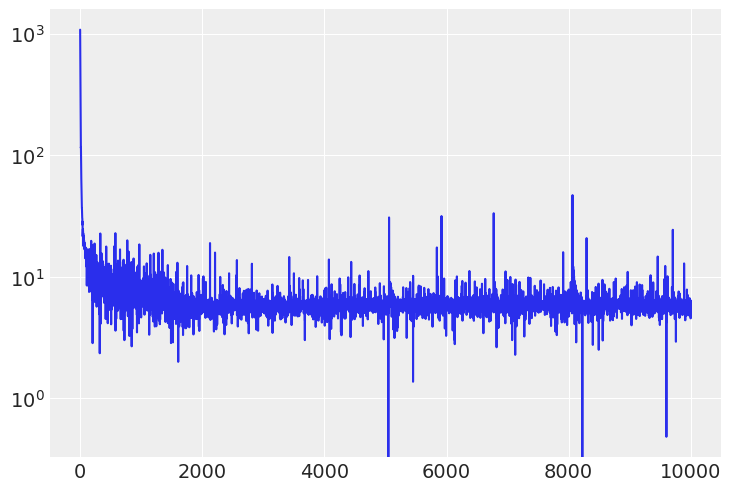

In [17]:
plt.plot(traced_loss.stack().numpy())
plt.yscale('log')

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy                  1.18.5
tensorflow_probability 0.12.0-dev20201001
pymc4                  4.0a2
tensorflow             2.4.0-dev20201001
last updated: Mon Oct 05 2020 

CPython 3.8.6
IPython 7.18.1
watermark 2.0.2
